This notebook generates the processed data for dataset ds005, which is used in some of the chapter-specific notebooks from Poldrack, Mumford, and Nichols' _Handbook of fMRI Data Analysis (2nd Edition)_.  This also provides an example of using the nipype workflow mechanism.

In [1]:
import os, errno, sys,shutil

from fmrihandbook.utils.config import Config

config=Config()

%matplotlib inline

from nipype.interfaces import fsl, nipy, ants
import nibabel
from wand.image import Image as WImage
import numpy
import nilearn.plotting
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiMasker
import fmrihandbook.utils
from fmrihandbook.utils.compute_fd_dvars import compute_fd,compute_dvars
import pickle
from fmrihandbook.utils.get_data import get_data

import nipype.interfaces.io as nio           # Data i/o
import nipype.pipeline.engine as pe          # pypeline engine
import nipype.algorithms.modelgen as model   # model specification
from nipype.interfaces.base import Bunch
import glob
import nipype.interfaces.utility as niu
from nipype.interfaces.c3 import C3dAffineTool
from nipype.interfaces.utility import Merge, IdentityInterface


rerun_analyses=False  # set to true to force rerun of everything



/Users/poldrack/anaconda/envs/py3k/lib/python3.5/importlib/_bootstrap_external.py:903: FutureWarning: Module nipy.labs.utils.routines deprecated, will be removed
  _imp.create_dynamic, spec)
/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/nipype/interfaces/nipy/model.py:18: FutureWarning: Module nipy.labs.glm deprecated, will be removed. Please use nipy.modalities.fmri.glm instead.
  import nipy.labs.glm.glm as GLM


using base dir: /Users/poldrack/data/fmri-handbook-2e-data


In [2]:
config.data=get_data('ds005')
print(config.data)

{'ds005': {'datadir': '/Users/poldrack/data/fmri-handbook-2e-data/ds005'}, 'ds031': {'T2': '/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-018/anat/sub-01_ses-018_run-001_T2w.nii.gz', 'func': '/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/func/sub-01_ses-014_task-nback_run-001_bold.nii.gz', 'fieldmap-mag': '/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/fmap/sub-01_ses-014_magnitude1.nii.gz', 'fieldmap-phasediff': '/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/fmap/sub-01_ses-014_phasediff.nii.gz', 'sbref': '/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/func/sub-01_ses-014_task-nback_run-001_sbref.nii.gz', 'datadir': '/Users/poldrack/data/fmri-handbook-2e-data/ds031', 'T1': '/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-018/anat/sub-01_ses-018_run-001_T1w.nii.gz'}}


## Structural workflow

In [3]:

subcodes=[os.path.basename(i) for i in glob.glob(os.path.join(config.data['ds005']['datadir'],'sub-*'))]
subcodes.sort()

print(subcodes)
datasource_anat = pe.Node(interface=nio.DataGrabber(infields=['subject_id'],
                                               outfields=['anat']),
                     name = 'datasource')
datasource_anat.inputs.base_directory = config.data['ds005']['datadir']

datasource_anat.inputs.template = '%s/anat/%s_T1w.nii.gz'
datasource_anat.inputs.template_args = dict(anat=[['subject_id','subject_id']])
#datasource_anat.inputs.subject_id = subcodes
datasource_anat.inputs.sort_filelist = True
datasource_anat.iterables = ('subject_id', subcodes)

infosource = pe.Node(niu.IdentityInterface(fields=['subject_id']),name='infosource')
infosource.iterables = [('subject_id',subcodes)]

                     
                                                   
preprocessing = pe.Workflow(name="preprocessing")
workdir=os.path.join(config.data['ds005']['datadir'],'nipype_workdir')
if not os.path.exists(workdir):
    os.mkdir(workdir)
preprocessing.base_dir = workdir


['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16']


### Bias field correction

In [4]:
bfc = pe.Node(interface=ants.N4BiasFieldCorrection(), name="bfc")
bfc.inputs.dimension = 3
bfc.inputs.save_bias = True

preprocessing.connect(datasource_anat, 'anat', bfc, 'input_image')

datasink = pe.Node(nio.DataSink(), name='datasink')
regex_subs = [('_combiner.*/sar', '/smooth/'),
              ('_combiner.*/ar', '/unsmooth/'),
              ('_aparc_ts.*/sar', '/smooth/'),
              ('_aparc_ts.*/ar', '/unsmooth/'),
              ('_getsubcortts.*/sar', '/smooth/'),
              ('_getsubcortts.*/ar', '/unsmooth/'),
              ('series/sar', 'series/smooth/'),
              ('series/ar', 'series/unsmooth/'),
              ('_inverse_transform./', ''),
              ]
# Save the relevant data into an output directory
datasink.inputs.base_directory = os.path.join(config.data['ds005']['datadir'],'derivatives')
if not os.path.exists(datasink.inputs.base_directory):
    os.mkdir(datasink.inputs.base_directory)

#datasink.inputs.substitutions = substitutions
#datasink.inputs.regexp_substitutions = regex_subs #(r'(/_.*(\d+/))', r'/run\2')
#datasink.inputs.container=os.path.join()

preprocessing.connect(bfc, 'bias_image', datasink, 'bfc.bias')
preprocessing.connect(bfc, 'output_image', datasink, 'bfc.output')



### Brain extraction using BET###

In [5]:
bet_struct=pe.Node(interface=fsl.BET(), name="bet_struct")
bet_struct.inputs.reduce_bias=True
bet_struct.inputs.frac=0.4

preprocessing.connect(bfc,'output_image',bet_struct,'in_file')
preprocessing.connect(bet_struct, 'out_file', datasink, 'bet.output')
preprocessing.connect(bet_struct, 'mask_file', datasink, 'bet.mask')

### Segmentation using FAST

Do this to obtain the white matter mask, which we need for BBR registration.

In [6]:
fast=pe.Node(interface=fsl.FAST(), name="fast")

preprocessing.connect(bet_struct,'out_file',fast,'in_files')
preprocessing.connect(fast, 'partial_volume_files', datasink, 'fast.pvefiles')
preprocessing.connect(fast, 'tissue_class_map', datasink, 'fast.seg')

binarize = pe.Node(fsl.ImageMaths(op_string='-nan -thr 0.5 -bin'),
                   name='binarize')
pickindex = lambda x, i: x[i]
preprocessing.connect(fast, ('partial_volume_files', pickindex, 2),
                 binarize, 'in_file')
preprocessing.connect(binarize, 'out_file', datasink, 'fast.wmseg')


### Spatial normalization using ANTs

In [7]:
antsreg=pe.Node(interface=ants.Registration(), name="antsreg")
antsreg.inputs.fixed_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz')
antsreg.inputs.transforms = ['Translation', 'Rigid', 'Affine', 'SyN']
antsreg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)]
antsreg.inputs.number_of_iterations = ([[10, 10, 10]]*3 +
                [[1, 5, 3]])
antsreg.inputs.dimension = 3
antsreg.inputs.write_composite_transform = True
antsreg.inputs.metric = ['Mattes'] * 3 + [['Mattes', 'CC']]
antsreg.inputs.metric_weight = [1] * 3 + [[0.5, 0.5]]
antsreg.inputs.radius_or_number_of_bins = [32] * 3 + [[32, 4]]
antsreg.inputs.sampling_strategy = ['Regular'] * 3 + [[None, None]]
antsreg.inputs.sampling_percentage = [0.3] * 3 + [[None, None]]
antsreg.inputs.convergence_threshold = [1.e-8] * 3 + [-0.01]
antsreg.inputs.convergence_window_size = [20] * 3 + [5]
antsreg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]]
antsreg.inputs.sigma_units = ['vox'] * 4
antsreg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]]*2 + [[4, 2, 1]]
antsreg.inputs.use_estimate_learning_rate_once = [True] * 4
antsreg.inputs.use_histogram_matching = [False] * 3 + [True]
antsreg.inputs.initial_moving_transform_com = True
antsreg.inputs.output_warped_image = True

preprocessing.connect(bet_struct,'out_file',antsreg,'moving_image')
preprocessing.connect(antsreg, 'warped_image', datasink, 'ants.warped_image')
preprocessing.connect(antsreg, 'composite_transform', datasink, 'ants.composite_transform')
preprocessing.connect(antsreg, 'inverse_composite_transform', datasink, 'ants.inverse_composite_transform')



## Functional preprocessing

### Motion correction using MCFLIRT

This will take a few minutes.

In [8]:
datasource_func = pe.Node(interface=nio.DataGrabber(infields=['subject_id','runcode'],
                                               outfields=['func']),
                     name = 'datasource_func')
datasource_func.inputs.base_directory = config.data['ds005']['datadir']

datasource_func.inputs.template = '%s/func/%s_task-mixedgamblestask_run-0%s_bold.nii.gz'
datasource_func.inputs.template_args = dict(func=[['subject_id','subject_id','runcode']])
#datasource_anat.inputs.subject_id = subcodes
datasource_func.inputs.sort_filelist = True
datasource_func.iterables = [('subject_id', subcodes),('runcode',['1','2','3'])]

mcflirt=pe.Node(interface=fsl.MCFLIRT(), name="mcflirt")
mcflirt.save_plots=True
mcflirt.mean_vol=True

preprocessing.connect(datasource_func, 'func', mcflirt, 'in_file')

preprocessing.connect(mcflirt, 'out_file', datasink, 'mcflirt.out_file')
preprocessing.connect(mcflirt, 'par_file', datasink, 'mcflirt.par')
preprocessing.connect(mcflirt, 'mean_img', datasink, 'mcflirt.mean')



Make links for the mean functional image and the motion parameters.

## Brain extraction

Use FSL's BET to obtain the brain mask for the functional data

In [9]:
bet_func=pe.Node(interface=fsl.BET(), name="bet_func")

bet_func.inputs.functional=True
bet_func.inputs.mask=True

preprocessing.connect(mcflirt, 'out_file', bet_func, 'in_file')

preprocessing.connect(bet_func, 'out_file', datasink, 'betfunc.out_file')
preprocessing.connect(bet_func, 'mask_file', datasink, 'betfunc.mask_file')

meanbetfunc=pe.Node(interface=fsl.MeanImage(), name="meanbetfunc")
preprocessing.connect(bet_func,'out_file',meanbetfunc,'in_file')
preprocessing.connect(meanbetfunc, 'out_file', datasink, 'betfunc.mean_file')



#### BBR registration of functional to structural

In [ ]:
mean2anat = pe.Node(fsl.FLIRT(), name='mean2anat')
mean2anat.inputs.dof = 6
preprocessing.connect(meanbetfunc, 'out_file', mean2anat, 'in_file')
preprocessing.connect(bet_struct, 'out_file', mean2anat, 'reference')

mean2anatbbr = pe.Node(fsl.FLIRT(), name='mean2anatbbr')
mean2anatbbr.inputs.dof = 6
mean2anatbbr.inputs.cost = 'bbr'
mean2anatbbr.inputs.schedule = os.path.join(os.getenv('FSLDIR'),
                                            'etc/flirtsch/bbr.sch')

preprocessing.connect(meanbetfunc, 'out_file', mean2anatbbr, 'in_file')
preprocessing.connect(binarize, 'out_file', mean2anatbbr, 'wm_seg')
preprocessing.connect(bet_struct, 'out_file', mean2anatbbr, 'reference')
preprocessing.connect(mean2anat, 'out_matrix_file',
                 mean2anatbbr, 'in_matrix_file')

preprocessing.connect(mean2anatbbr, 'out_matrix_file', datasink, 'bbr.out_matrix')
preprocessing.connect(mean2anatbbr, 'out_file', datasink, 'bbr.out_file')

# convert BBR matrix to ITK for ANTS

convert2itk = pe.Node(C3dAffineTool(),
                      name='convert2itk')
convert2itk.inputs.fsl2ras = True
convert2itk.inputs.itk_transform = True
preprocessing.connect(mean2anatbbr, 'out_matrix_file', convert2itk, 'transform_file')
preprocessing.connect(meanbetfunc, 'out_file', convert2itk, 'source_file')
preprocessing.connect(bet_struct, 'out_file', convert2itk, 'reference_file')

In [ ]:
# Concatenate the affine and ants transforms into a list

pickfirst = lambda x: x[0]

merge = pe.Node(Merge(2), iterfield=['in2'], name='mergexfm')
preprocessing.connect(convert2itk, 'itk_transform', merge, 'in2')
preprocessing.connect(antsreg, 'composite_transform', merge, 'in1')

warpmean = pe.Node(ants.ApplyTransforms(), name='warpmean')
warpmean.inputs.input_image_type = 0
warpmean.inputs.interpolation = 'Linear'
warpmean.inputs.invert_transform_flags = [False, False]
warpmean.inputs.terminal_output = 'file'
warpmean.inputs.args = '--float'
warpmean.inputs.reference_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz')

warpall = pe.MapNode(ants.ApplyTransforms(),
                     iterfield=['input_image'],
                     name='warpall')
warpall.inputs.input_image_type = 0
warpall.inputs.interpolation = 'Linear'
warpall.inputs.invert_transform_flags = [False, False]
warpall.inputs.terminal_output = 'file'
warpall.inputs.args = '--float'
warpall.inputs.num_threads = 2
warpall.plugin_args = {'sbatch_args': '--mem=6G -c 2'}
warpall.inputs.reference_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz')


preprocessing.connect(meanbetfunc, 'out_file', warpmean, 'input_image')
preprocessing.connect(merge, 'out', warpmean, 'transforms')
preprocessing.connect(bet_func, 'out_file', warpall, 'input_image')
preprocessing.connect(merge, 'out', warpall, 'transforms')

graph=preprocessing.run()

/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
INFO:workflow:['check', 'execution', 'logging']
INFO:workflow:Running serially.
INFO:workflow:Executing node datasource_func.aI.a31 in dir: /Users/poldrack/data/fmri-handbook-2e-data/ds005/nipype_workdir/preprocessing/_runcode_2_subject_id_sub-11/datasource_func
INFO:workflow:Executing node datasource_func.aI.a22 in dir: /Users/poldrack/data/fmri-handbook-2e-data/ds005/nipype_workdir/preprocessing/_runcode_2_subject_id_sub-08/datasource_func
I

In [ ]:
for subcode in subcodes:
    antsregfile=os.path.join(config.data['ds005']['datadir'],
                             'derivatives/ants/warped_image/_subject_id_%s/transform_Warped.nii.gz'%subcode)
    if os.path.exists(antsregfile):
        mask_display=nilearn.plotting.plot_epi(anstregfile,cmap='gray')
        mask_display.add_contours(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                                  levels=[.5])

Compute and plot the global signal within the mask across timepoints

In [13]:
niftimasker=NiftiMasker(mask_img=config.data['meanfunc_brain_mask'])
bolddata_masked=niftimasker.fit_transform(config.data['func_mcf'])
globalmean=numpy.mean(bolddata_masked,1)

### QA for fMRI data

Load motion data and compute FD/DVARS

In [14]:
motiondata=numpy.loadtxt(config.data['motionpar'])
fd=compute_fd(motiondata)
dvars=compute_dvars(globalmean)
outputdir=os.path.dirname(config.data['motionpar'])
config.data['FD']=os.path.join(outputdir,'FD.txt')
config.data['DVARS']=os.path.join(outputdir,'DVARS.txt')
numpy.savetxt(config.data['FD'],fd)
numpy.savetxt(config.data['DVARS'],dvars)

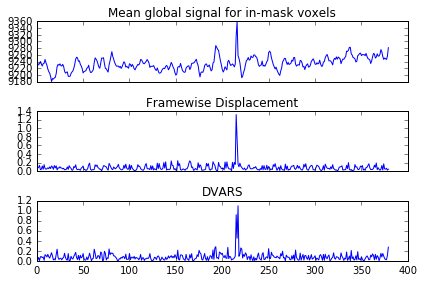

In [15]:
f, (ax1, ax2,ax3)=plt.subplots(3, sharex=True)
ax1.plot(globalmean)
ax1.set_title('Mean global signal for in-mask voxels')

ax2.plot(fd)
ax2.set_title('Framewise Displacement')

ax3.plot(dvars)
ax3.set_title('DVARS')
plt.tight_layout()

## Corregistration using boundary based registration

In [22]:
try:
    assert os.path.exists(config.data['meanfunc_bbreg_to_t1'])
    assert os.path.exists(config.data['meanfunc_bbreg_to_t1_mat'])
    assert os.path.exists(config.data['meanfunc_bbreg_to_t1_invmat'])
    assert os.path.exists(config.data['meanfunc_unwarped_bbreg_to_t1'])
    assert not rerun_analyses
except:
    epi_reg = mem.cache(fsl.EpiReg)
    epi_reg_results=epi_reg(epi=config.data['meanfunc'],
                              t1_head=config.data['T1_bc'],
                              t1_brain=config.data['T1_brain'],
                              fmap=config.data['fieldmap'],
                              fmapmag=config.data['fieldmap-mag'],
                              fmapmagbrain=config.data['fieldmap-mag_brain'],
                              echospacing=2.6/10000.0,
                              pedir='y',
                              out_base="epi2struct")
    
    outputdir=os.path.dirname(config.data['meanfunc'])
    config.data['meanfunc_bbreg_to_t1']=os.path.join(outputdir, "epi_bbreg_to_t1.nii.gz")
    config.data['meanfunc_bbreg_to_t1_mat']=os.path.join(outputdir, "epi_bbreg_to_t1.mat")
    config.data['meanfunc_bbreg_to_t1_invmat']=os.path.join(outputdir, "epi_bbreg_to_t1_inv.mat")
    
    shutil.copy(epi_reg_results.outputs.out_file, config.data['meanfunc_bbreg_to_t1'])
    shutil.copy(epi_reg_results.outputs.epi2str_mat , config.data['meanfunc_bbreg_to_t1_mat'])
    shutil.copy(epi_reg_results.outputs.epi2str_inv , config.data['meanfunc_bbreg_to_t1_invmat'])
    print(epi_reg_results.outputs)
    config.data['meanfunc_unwarped_bbreg_to_t1']=os.path.join(outputdir,'epi_unwarped_bbreg_to_t1.nii.gz')
    
    flirt=mem.cache(fsl.FLIRT)
    config.data['meanfunc_unwarped_bbref_to_t1']=os.path.join(outputdir,'epi_unwarped_bbreg_to_t1.nii.gz')
    flirt_results=flirt(in_file=config.data['meanfunc_unwarped'],
                        out_file=config.data['meanfunc_unwarped_bbreg_to_t1'],
                        apply_xfm=True,in_matrix_file=config.data['meanfunc_bbreg_to_t1_mat'],
                        reference=config.data['meanfunc_unwarped'])


INFO:workflow:Executing node 659be6478b481f6e83f05cfd8f650da7 in dir: /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/659be6478b481f6e83f05cfd8f650da7
INFO:workflow:Running: epi_reg --echospacing=0.000260 --fmap=/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/fmap/sub-01_ses-014_fieldmap.nii.gz --fmapmag=/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/fmap/sub-01_ses-014_magnitude1.nii.gz --fmapmagbrain=/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/fmap/sub-01_ses-014_magnitude1_brain.nii.gz --pedir=y --epi=/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/func/sub-01_ses-014_task-nback_run-001_bold_mcf.nii.gz_mean_reg.nii.gz --t1=/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-018/anat/sub-01_ses-018_run-001_T1w_corrected.nii.gz --t1brain=/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-018/anat/sub-01_ses-018_run-001_T1w_corrected_bra


epi2str_inv = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/659be6478b481f6e83f05cfd8f650da7/epi2struct_inv.mat
epi2str_mat = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/659be6478b481f6e83f05cfd8f650da7/epi2struct.mat
fmap2epi_mat = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/659be6478b481f6e83f05cfd8f650da7/epi2struct_fieldmaprads2epi.mat
fmap2str_mat = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/659be6478b481f6e83f05cfd8f650da7/epi2struct_fieldmap2str.mat
fmap_epi = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/659be6478b481f6e83f05cfd8f650da7/epi2struct_fieldmaprads2epi.nii.gz
fmap_str = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPre

INFO:workflow:Executing node a884c481642abb58d8fa480415c93e99 in dir: /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/a884c481642abb58d8fa480415c93e99
INFO:workflow:Running: antsApplyTransforms --default-value 0 --input /Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-018/anat/sub018_t1_corrected_brain_wmseg.nii.gz --interpolation NearestNeighbor --output sub018_t1_corrected_brain_wmseg_trans.nii.gz --reference-image /Applications/fmri_progs/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz --transform /Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-018/anat/t1_to_mni_warp.h5


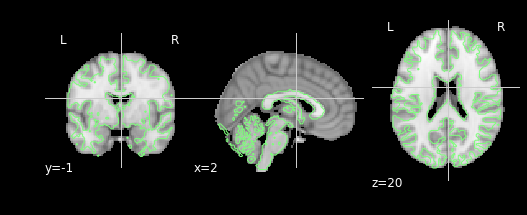

In [23]:
try:
    assert os.path.exists(config.data['T1_wmseg_mni'])
    assert not rerun_analyses
except:
    T1_to_MNI_warp = mem.cache(ants.ApplyTransforms)
    T1wm_to_MNI_warp_results = T1_to_MNI_warp(input_image = config.data['T1_wmseg'],
                reference_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                interpolation = "NearestNeighbor",
                transforms = config.data['T1_mni_warp'])

    output_dir=os.path.dirname(config.data['T1_wmseg'])
    config.data['T1_wmseg_mni']=os.path.join(output_dir,os.path.basename(T1wm_to_MNI_warp_results.outputs.output_image))
    shutil.copy(T1wm_to_MNI_warp_results.outputs.output_image,config.data['T1_wmseg_mni'])

fig = nilearn.plotting.plot_anat(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))
fig.add_contours(config.data['T1_wmseg_mni'], levels=[.5]) 

## Spatial smoothing

Perform spatial smoothing using Gaussian kernel. Can you spot the difference between top and bottom rows?

INFO:workflow:Executing node c4df9fd00f7de1eef3c8a04c12deb93c in dir: /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-utils-Smooth/c4df9fd00f7de1eef3c8a04c12deb93c
INFO:workflow:Running: fslmaths /Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/func/sub-01_ses-014_task-nback_run-001_bold_mcf.nii.gz -kernel gauss 1.061652 -fmean /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-utils-Smooth/c4df9fd00f7de1eef3c8a04c12deb93c/sub-01_ses-014_task-nback_run-001_bold_mcf_smooth.nii


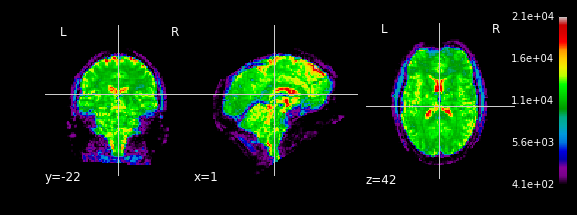

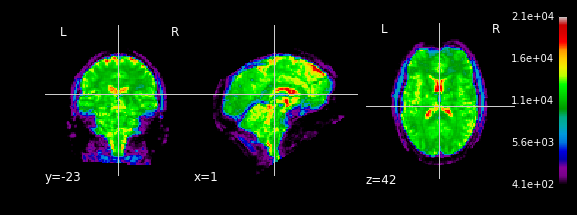

In [24]:
try:
    assert os.path.exists(config.data['func_mcf_smooth'])
    assert not rerun_analyses
except:
    smooth = mem.cache(fsl.utils.Smooth)
    smooth_results = smooth(fwhm=2.5,
                            in_file=config.data['func_mcf'],
                            output_type = "NIFTI")
    output_dir=os.path.dirname(config.data['func_mcf'])
    config.data['func_mcf_smooth']=os.path.join(output_dir,
                        os.path.basename(smooth_results.outputs.smoothed_file))
    shutil.copy(smooth_results.outputs.smoothed_file,config.data['func_mcf_smooth'])

nilearn.plotting.plot_epi(config.data['meanfunc'],
                              colorbar=True, vmin=410, vmax=21000)
nilearn.plotting.plot_epi(nilearn.image.mean_img(config.data['func_mcf_smooth']),
                              colorbar=True, vmin=410, vmax=21000)

## High pass filtering

High-pass filtering - this will take a few minutes

In [25]:
try:
    assert os.path.exists(config.data['func_mcf_smooth_hpf_rescaled'])
    assert not rerun_analyses
except:

    hpfilt = mem.cache(fsl.maths.TemporalFilter)
    TR = 1.16
    hpfilt_results = hpfilt(highpass_sigma = 100/(2*TR),
                            in_file=config.data['func_mcf_smooth'],
                            output_type = "NIFTI")

    mean = mem.cache(fsl.maths.MeanImage)
    mean_results = mean(in_file = config.data['func_mcf_smooth'])

    rescale = mem.cache(fsl.maths.BinaryMaths)
    rescale_results = rescale(in_file=hpfilt_results.outputs.out_file,
                              operand_file = mean_results.outputs.out_file,
                              operation = "add",
                              output_type = "NIFTI")
    output_dir=os.path.dirname(config.data['func_mcf_smooth'])
    config.data['func_mcf_smooth_hpf_rescaled']=os.path.join(output_dir,
                                    os.path.basename(rescale_results.outputs.out_file))
    shutil.copy(rescale_results.outputs.out_file,config.data['func_mcf_smooth_hpf_rescaled'])


INFO:workflow:Executing node 575a761dff31a4ed7e696f9aff6e3564 in dir: /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-maths-TemporalFilter/575a761dff31a4ed7e696f9aff6e3564
INFO:workflow:Running: fslmaths /Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/func/sub-01_ses-014_task-nback_run-001_bold_mcf_smooth.nii -bptf 43.103448 -1.000000 /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-maths-TemporalFilter/575a761dff31a4ed7e696f9aff6e3564/sub-01_ses-014_task-nback_run-001_bold_mcf_smooth_filt.nii
INFO:workflow:Executing node accc214fab09b3a36e149b2070d90ccc in dir: /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-maths-MeanImage/accc214fab09b3a36e149b2070d90ccc
INFO:workflow:Running: fslmaths /Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/func/sub-01_ses-014_task-nback_run-001_bold_mcf_smooth.nii -T

Save data dictionary

In [26]:
import pickle
pickle.dump(config.data,open(config.datadict,'wb'))